# Data Exploration

In [1]:
# import polars as pl
import pandas as pd
import ray
# import modin.pandas as md
from pandarallel import pandarallel
# import time
# import json
import swifter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, kstest

from rapidfuzz import process

In [296]:
ray.shutdown()

In [ ]:
ray.init()

In [2]:
%%time

# data = pd.read_parquet("../data/interim/chrome/08_12_2022/http.0.parquet.gzip")
# data1 = pd.read_parquet("../data/interim/chrome/08_12_2022/http.1.parquet.gzip")
# data2 = pd.read_parquet("../data/interim/chrome/08_12_2022/http.2.parquet.gzip")
# data3 = pd.read_parquet("../data/interim/chrome/08_12_2022/http.3.parquet.gzip")
# data4 = pd.read_parquet("../data/interim/chrome/08_12_2022/http.4.parquet.gzip")
# data5 = pd.read_parquet("../data/interim/chrome/08_12_2022/http.5.parquet.gzip")

data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01.parquet.gzip"
)

CPU times: user 15.4 s, sys: 3.91 s, total: 19.3 s
Wall time: 21.5 s


In [229]:
# pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
%%time
data

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


,hostname,pathname,filetype,filename,protocol,query,pragma,content-type,last-modified,accept-ranges,...,xc-version,x-amzn-waf-action,generated,x-amz-req-time-micros,debug_plat_b,x-ta,x-cache-cms-status,x-pbs-appsvrname,x-pbs-appsvrip,tracker
256683,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,https:,[],None,text/javascript; charset=utf-8,None,None,...,None,None,None,None,None,None,None,None,None,1
14233,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,https:,[],None,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",None,...,None,None,None,None,None,None,None,None,None,0
100818,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,https:,"[[t, sr], [aip, 1], [_r, 4], [slf_rd, 1], [v, ...",no-cache,image/gif,None,None,...,None,None,None,None,None,None,None,None,None,1
106109,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,https:,"[[c, de], [n, 16509], [v, 106], [e, 1660303693...",no-cache,None,None,None,...,None,None,None,None,None,None,None,None,None,0
126395,shimo.im,/,/,,https:,[],None,text/html; charset=utf-8,None,None,...,None,None,None,None,None,None,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31179,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,https:,[],None,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,...,None,None,None,None,None,None,None,None,None,0
9931,ads.adfox.ru,/260122/event,/260122/event,event,https:,"[[pm, cyz], [hash, 189c77c15f8caeb6], [duid, 1...",no-cache,None,"fri, 12 aug 2022 09:22:13 gmt",None,...,None,None,None,None,None,None,None,None,None,1
256544,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,https:,[],None,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,...,None,None,None,None,None,None,None,None,None,0
184101,tenor.com,/opensearch.xml,xml,opensearch.xml,https:,[],None,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,...,None,None,None,None,None,None,None,None,None,0


In [ ]:
data.isna().sum()

In [4]:
data.info(memory_usage="deep")

# 14GB -> 763MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168038 entries, 0 to 168037
Columns: 3891 entries, easylist to x-styx-origin-id
dtypes: bool(2), object(3889)
memory usage: 14.8 GB


In [8]:
data.dtypes

hostname              object
pathname              object
filetype              object
filename              object
protocol              object
                       ...  
debug_plat_b          object
x-ta                  object
x-cache-cms-status    object
x-pbs-appsvrname      object
x-pbs-appsvrip        object
Length: 5316, dtype: object

### Exploration with New Datatypes

In [116]:
(data.isna().sum() / len(data)) >= 0.95

hostname                  False
pathname                  False
filetype                  False
filename                  False
protocol                  False
                          ...  
x-client-geo-region        True
x-client-geo-metrocode     True
x-client-geo-zip           True
mid                        True
tracker                   False
Length: 3920, dtype: bool

### Check Tracking Classification and Create New Label Column

In [270]:
data["easylist"] = data["easylist"].astype(np.int32)
data["easyprivacy"] = data["easyprivacy"].astype(np.int32)

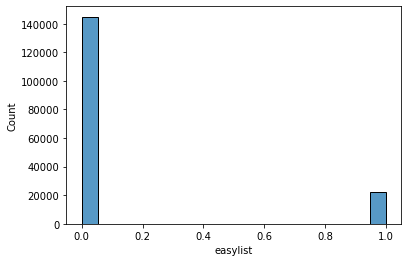

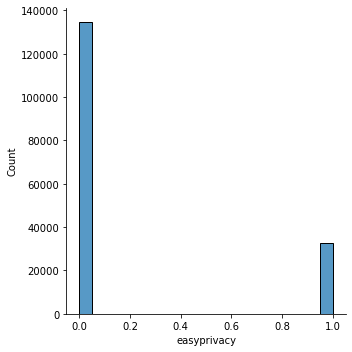

In [9]:
sns.histplot(data, x="easylist")
sns.displot(data, x="easyprivacy")

In [271]:
data["tracker"] = np.where(
    np.logical_or(data.easylist == 1, data.easyprivacy == 1), 1, 0
)
data["tracker"] = data["tracker"].astype(np.int32)

In [272]:
%%time
data.drop(["easylist", "easyprivacy"], axis=1, inplace=True)

CPU times: user 5.62 s, sys: 3.46 s, total: 9.08 s
Wall time: 10.5 s


<AxesSubplot:xlabel='tracker', ylabel='Count'>

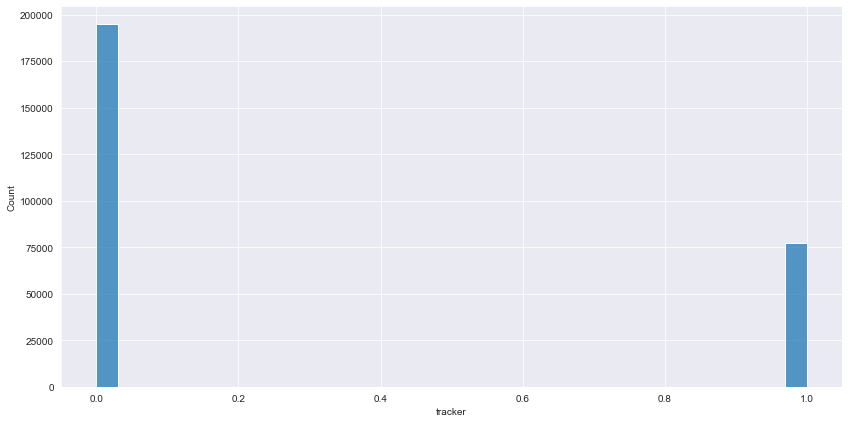

In [4]:
plt.figure(figsize=(14, 7))
sns.histplot(data, x="tracker")

In [295]:
data['tracker'].value_counts()

class_0 = len(data[data['tracker'] == 0]) / 10000
class_1 = len(data[data['tracker'] == 1]) / 10000

class_distribution_ratio = class_1 / class_0
print(class_distribution_ratio)
print(class_0, class_1)

0.372391311470039
12.2092 4.5466


#### Remove empty columns

In [13]:
%%time
empty_columns = [col for col in data if data[col].isnull().all() == True]

CPU times: user 18 s, sys: 3.47 s, total: 21.5 s
Wall time: 24.2 s


In [14]:
data.drop(empty_columns, axis = 1, inplace = True)

### Put tracker col as last column

In [32]:
# https://sparkbyexamples.com/pandas/pandas-change-position-of-a-column/
temp_cols = data.columns.tolist()
index_col = data.columns.get_loc("tracker")
new_col_order = temp_cols[0:index_col] + temp_cols[index_col+1:] + temp_cols[index_col:index_col+1]

data = data[new_col_order]

#### Remove duplicate columns

In [81]:
data = data[~data.iloc[:, 6:-2].duplicated(keep="first")].reset_index(drop=True)

#### Add #Values per HTTP Message

In [17]:
%%time
data['header_count'] = data.iloc[:,6:-1].notnull().sum(axis=1)

CPU times: user 2min 5s, sys: 14.5 s, total: 2min 20s
Wall time: 2min 28s


### Check Column Name Similarity

In [5]:
def new_fuzzy_string_matching_for_column(col_name, col_values):
    result = pd.DataFrame(
        process.extract(
            col_name, col_values, processor=None, score_cutoff=80, limit=100
        ),
        columns=["fuzzy_match", "w_ratio", "index"],
    )
    result["col_name"] = col_name
    return result

In [15]:
%%time
data_column_values = data.columns.values[6:-2].tolist()

match = [
    new_fuzzy_string_matching_for_column(j, data_column_values[i + 1 :])
    for i, j in enumerate(data_column_values)
    if i != len(data_column_values) - 1
]

match2 = pd.concat(match, ignore_index=True)
print(match2)

                     fuzzy_match    w_ratio index                 col_name
0                        pragrma  92.307692  3532                   pragma
1      x-akamai-pragma-client-ip       90.0   390                   pragma
2               pragma-directive       90.0  2534                   pragma
3                         pramga  83.333333  1041                   pragma
4                 x-content-type  92.307692   722             content-type
...                          ...        ...   ...                      ...
25931                  generated       80.0    25       x-generateguestjwt
25932                    x-width       90.0     8                      wid
25933    nrk-application-version       90.0     0          nrk-application
25934                 xc-version       80.0    12  nrk-application-version
25935                  x-adstyle  82.352941     2                 x-adtype

[25936 rows x 4 columns]
CPU times: user 17.8 s, sys: 177 ms, total: 18 s
Wall time: 18 s


Indices from match2 are wrong

In [12]:
match2[match2['col_name'] == 'server']

,fuzzy_match,w_ratio,index,col_name
197,xserver,92.307692,140,server
198,pserver,92.307692,3033,server
199,tserver,92.307692,3570,server
200,jserver,92.307692,4595,server
201,server-timing,90.0,24,server
...,...,...,...,...
292,cw-server,90.0,2675,server
293,x-bo-server,90.0,2698,server
294,servername,90.0,2706,server
295,serverresponsetime,90.0,2707,server


In [10]:
def find_cols_with_similar_values(fuzzy_match, column):
    value_fuzzy = set(data[fuzzy_match].values)
    value_column = set(data[column].values)

    try:
        value_fuzzy.remove(None)
        value_column.remove(None)
    except KeyError:
        pass

    if (len([True for i in value_fuzzy if i in value_column]) / len(value_fuzzy)) > 0.5:
        return fuzzy_match, column
    else:
        return None

In [8]:
def select_similar_columns(fuzzy_match, column):
    row = match2.loc[(match2['fuzzy_match'] == fuzzy_match) & (match2['col_name'] == column)]
    index = row.index[0]
    match2.drop(index, inplace=True)
    return row

In [16]:
%%time
result = [find_cols_with_similar_values(col, col2) for col, col2 in zip(match2['fuzzy_match'], match2['col_name'])]
result

CPU times: user 3min 18s, sys: 3.73 s, total: 3min 22s
Wall time: 3min 22s


[('pragrma', 'pragma'),
 None,
 ('pragma-directive', 'pragma'),
 ('pramga', 'pragma'),
 None,
 ('content_type', 'content-type'),
 ('contetn-type', 'content-type'),
 None,
 None,
 None,
 ('x-tb-optimization-original-content-type', 'content-type'),
 None,
 ('x-hs-alternate-content-type', 'content-type'),
 ('x-upyun-content-type', 'content-type'),
 ('x-amz-meta-content-type', 'content-type'),
 ('x-tb-oa-originalcontenttype', 'content-type'),
 None,
 ('content-style-type', 'content-type'),
 None,
 ('x-nyt-data-last-modified', 'last-modified'),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ('x-accept-ranges', 'accept-ranges'),
 None,
 ('x-amz-meta-accept-ranges', 'accept-ranges'),
 None,
 None,
 None,
 None,
 None,
 None,
 ('x-xss-protections', 'x-xss-protection'),
 None,
 None,
 ('x-content-type-option', 'x-content-type-options'),
 None,
 None,
 None,
 ('x-content-options', 'x-content-type-options'),
 ('x-control-type-options', 'x-content-type-options'),
 None,
 No

In [17]:
similar_values = [select_similar_columns(col[0], col[1]) for col in result if col is not None]

In [18]:
similar_values = pd.concat(similar_values, ignore_index=True)

In [19]:
similar_values

,fuzzy_match,w_ratio,index,col_name
0,pragrma,92.307692,3532,pragma
1,pragma-directive,90.0,2534,pragma
2,pramga,83.333333,1041,pragma
3,content_type,91.666667,1449,content-type
4,contetn-type,91.666667,4032,content-type
...,...,...,...,...
1634,x-cache-nx,80.0,3,x-cache-vf
1635,x-cache-cms-status,80.0,151,x-cache-vf
1636,x-cache-nx,80.0,0,x-cache-ve
1637,x-cache-cms-status,80.0,148,x-cache-ve


In [20]:
data.reset_index(drop=True, inplace=True)

In [21]:
def merge_similar_columns2(fuzzy_match, col_name):
    boolean_mask = data[fuzzy_match].notnull()
    new_values = data[boolean_mask][fuzzy_match].to_numpy()
    indices_fuzzy_matches = data.index[boolean_mask].tolist()

    current_values = data[col_name].to_numpy()
    np.put(current_values, indices_fuzzy_matches, new_values)
    # data_copy.drop(fuzzy_match, axis=1, inplace=True)

In [22]:
%%time
similar_values.apply(lambda x: merge_similar_columns2(x['fuzzy_match'], x['col_name']), axis=1)
# data_copy.loc[(data_copy['pramga'] == 'no-cache') & (data_copy['pragma'] == 'no-cache')][['pragma', 'pramga']]
# data_copy.loc[(data_copy['pragma'] == 'no-cache')]['pragma']

CPU times: user 20.4 s, sys: 839 ms, total: 21.2 s
Wall time: 21.2 s


0       None
1       None
2       None
3       None
4       None
        ... 
1634    None
1635    None
1636    None
1637    None
1638    None
Length: 1639, dtype: object

In [24]:
columns_to_remove = list(set(similar_values.fuzzy_match.values.tolist()))
data.drop(columns_to_remove, axis=1, inplace=True)

### Exploration

In [62]:
%matplotlib inline
plt.figure(figsize=(20, 10))

ct_values = data[["content-type", "tracker"]].dropna()

ct_values

data[['content-type', 'tracker']].value_counts().head(20)

content-type                           tracker
image/jpeg                             0          20179
application/javascript                 0          14993
image/png                              0          13666
image/webp                             0          11292
image/gif                              1          10577
image/svg+xml                          0           8916
text/css                               0           6858
application/javascript; charset=utf-8  0           6557
application/x-javascript               0           4292
application/javascript; charset=utf-8  1           3532
application/javascript                 1           3490
application/json                       0           3312
text/javascript                        1           3270
font/woff2                             0           3230
text/html; charset=utf-8               0           3034
text/plain                             1           2875
application/json; charset=utf-8        0           2441
t

<Figure size 1440x720 with 0 Axes>

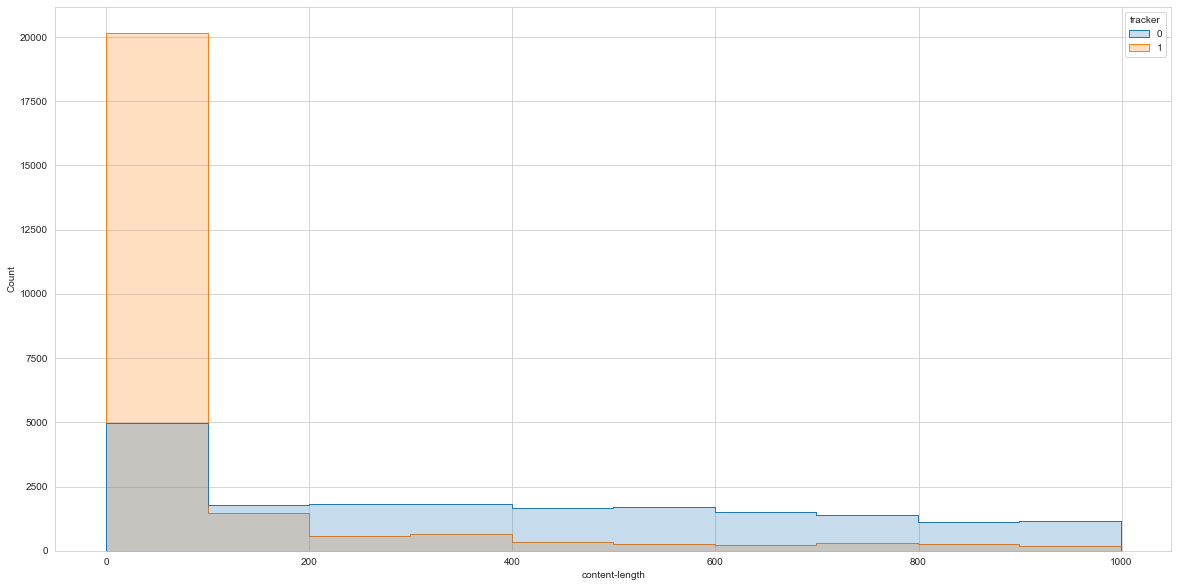

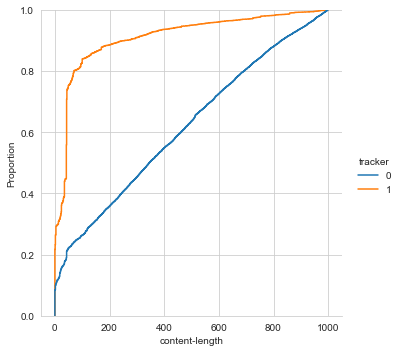

In [64]:
%matplotlib inline
plt.figure(figsize=(20, 10))
cl_values = data[["content-length", "tracker"]].dropna().astype('Int32')
sns.histplot(cl_values[cl_values['content-length'] < 1000], bins=10, x="content-length", hue='tracker', element='step')

sns.displot(cl_values[cl_values['content-length'] < 1000], x="content-length", kind='ecdf', hue='tracker')
plt.show()

In [138]:
match2[match2.col_name == "content-length"]

,fuzzy_match,w_ratio,index,col_name
193,content-lenght,92.857143,1741,content-length
194,content-ex-length,90.322581,3720,content-length
195,x-goog-stored-content-length,90.0,144,content-length
196,x-original-content-length,90.0,828,content-length
197,x-amzn-remapped-content-length,90.0,1006,content-length
198,original-content-length,90.0,1274,content-length
199,x-xiaomi-meta-content-length,90.0,1529,content-length
200,x-upyun-content-length,90.0,1629,content-length
201,x-hola-original-content-length,90.0,1936,content-length
202,cteonnt-length,85.714286,618,content-length


### Explore Distributions

Text(0.5, 1.0, 'Distribution of #NAs Across All Columns')

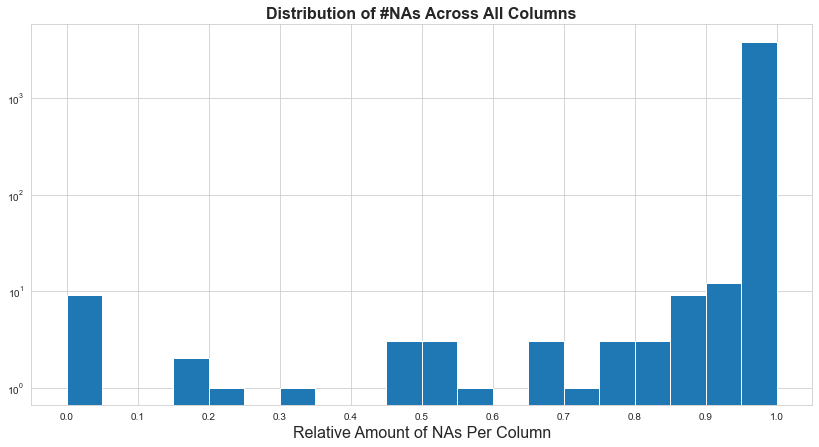

In [580]:
relative_na_per_col = pd.DataFrame((data.isna().sum() / len(data)), columns=["summary"])

plt.figure(figsize=(14, 7))
plt.hist(relative_na_per_col["summary"], log=True, bins=20)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Relative Amount of NAs Per Column", fontdict={"fontsize": 16})
plt.title("Distribution of #NAs Across All Columns", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'Distribution of #Values Across All Columns')

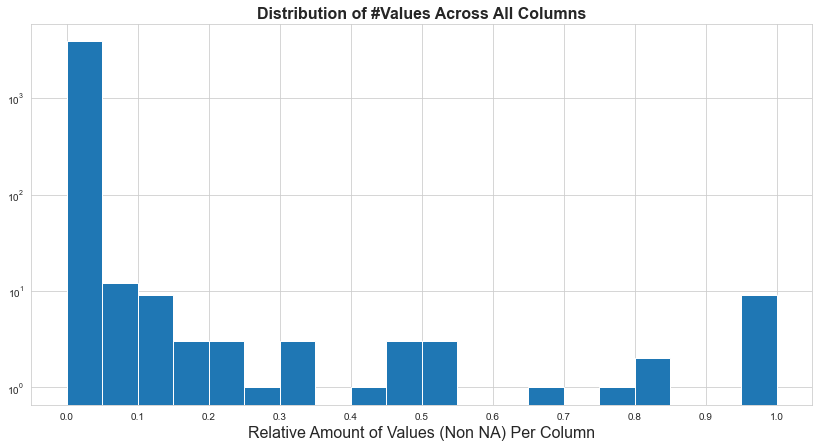

In [579]:
relative_values_per_col = pd.DataFrame((data.count() / len(data)), columns=["summary"])

plt.figure(figsize=(14, 7))
plt.hist(relative_values_per_col["summary"], log=True, bins=20)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Relative Amount of Values (Non NA) Per Column", fontdict={"fontsize": 16})
plt.title("Distribution of #Values Across All Columns", fontsize=16, fontweight="bold")

In [139]:
rel_frequency_per_col = (
    data.groupby("tracker").count() / data.groupby("tracker").count().sum()
)
rel_frequency_per_col.transpose()

tracker,0,1
hostname,0.728655,0.271345
pathname,0.728655,0.271345
filetype,0.728655,0.271345
filename,0.728655,0.271345
protocol,0.728655,0.271345
...,...,...
x-client-geo-city,1.000000,0.000000
x-client-geo-region,1.000000,0.000000
x-client-geo-metrocode,1.000000,0.000000
x-client-geo-zip,1.000000,0.000000


In [111]:
columns_with_more_trackers = rel_frequency_per_col.iloc[
    :, np.where([rel_frequency_per_col.iloc[1, :] > 0.5])[1]
].transpose()
columns_with_more_trackers["total_frequency"] = (
    data[columns_with_more_trackers.index.values].count().values
)
columns_with_more_trackers["total_nas"] = (
    data[columns_with_more_trackers.index.values].isna().sum().values
)
columns_with_more_trackers["ratio_value_total"] = columns_with_more_trackers[
    "total_frequency"
] / len(data)

columns_with_more_trackers.sort_values(by=["total_frequency"], ascending=False)

tracker,0,1,total_frequency,total_nas,ratio_value_total
alt-svc,0.487842,0.512158,37713,129845,0.225074
cross-origin-resource-policy,0.316124,0.683876,25936,141622,0.154788
access-control-allow-credentials,0.467669,0.532331,22873,144685,0.136508
pragma,0.267543,0.732457,20550,147008,0.122644
p3p,0.193632,0.806368,15483,152075,0.092404
...,...,...,...,...,...
x-marintrackerversion,0.000000,1.000000,1,167557,0.000006
tk,0.000000,1.000000,1,167557,0.000006
disposition,0.000000,1.000000,1,167557,0.000006
x-onead-guid,0.000000,1.000000,1,167557,0.000006


In [112]:
columns_with_more_non_trackers = rel_frequency_per_col.iloc[
    :, np.where([rel_frequency_per_col.iloc[0, :] > 0.5])[1]
].transpose()
columns_with_more_non_trackers["total_frequency"] = (
    data[columns_with_more_non_trackers.index.values].count().values
)
columns_with_more_non_trackers["total_nas"] = (
    data[columns_with_more_non_trackers.index.values].isna().sum().values
)
columns_with_more_non_trackers["ratio_value_total"] = columns_with_more_non_trackers[
    "total_frequency"
] / len(data)

columns_with_more_non_trackers.sort_values(by=["total_frequency"], ascending=False)

tracker,0,1,total_frequency,total_nas,ratio_value_total
hostname,0.728655,0.271345,167558,0,1.000000
protocol,0.728655,0.271345,167558,0,1.000000
query,0.728655,0.271345,167558,0,1.000000
pathname,0.728655,0.271345,167558,0,1.000000
filename,0.728655,0.271345,167558,0,1.000000
...,...,...,...,...,...
x-request-minified,1.000000,0.000000,1,167557,0.000006
x-smart-cache,1.000000,0.000000,1,167557,0.000006
x-smart-cache-id,1.000000,0.000000,1,167557,0.000006
x-smart-cache-ttl,1.000000,0.000000,1,167557,0.000006


(array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

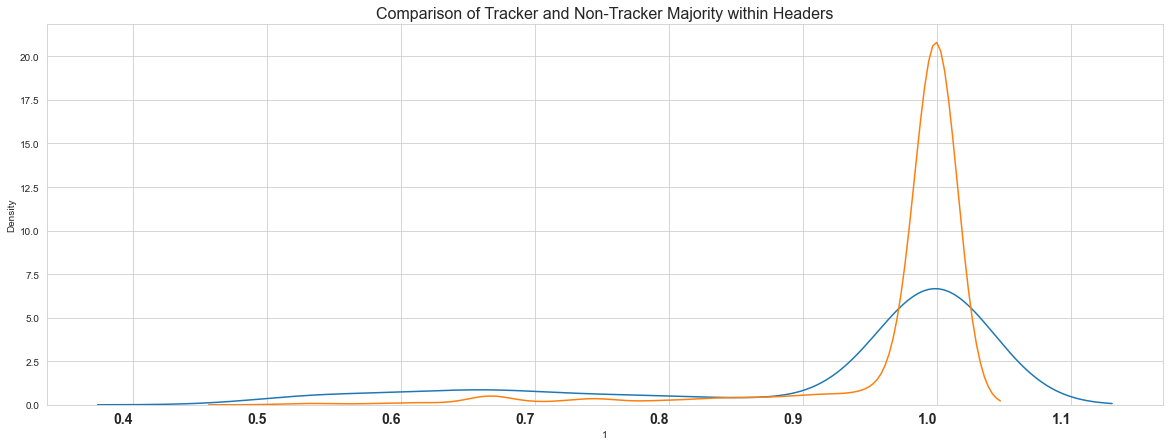

In [115]:
plt.figure(figsize=(20, 7))
sns.kdeplot(columns_with_more_trackers.iloc[:, 1])
sns.kdeplot(columns_with_more_non_trackers.iloc[:, 0])
plt.title(
    "Comparison of Tracker and Non-Tracker Majority within Headers",
    fontdict={"fontsize": 16},
)
plt.xticks(fontsize=14, fontweight="bold", ha="right")

Text(0.5, 0.98, 'Relative Frequency per Column by Tracker Classification')

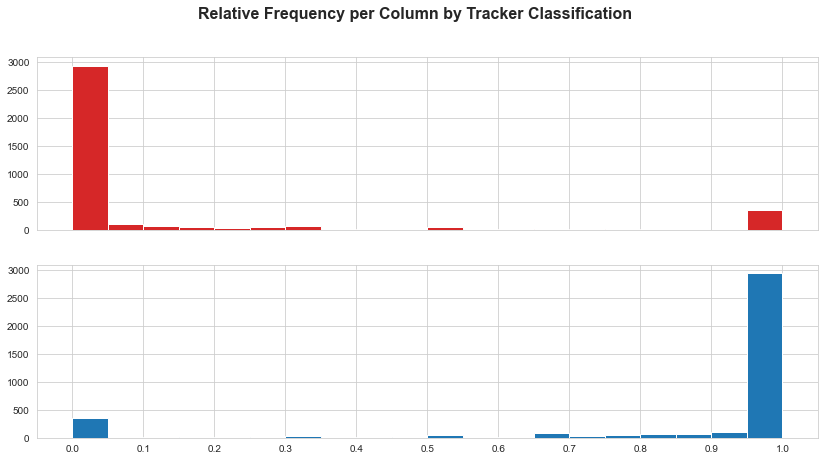

In [577]:
fig, ax = plt.subplots(2, sharex=True, figsize=(14, 7))

ax[0].hist(rel_frequency_per_col.loc[1, :], bins=20, color="tab:red")
ax[1].hist(rel_frequency_per_col.loc[0, :], bins=20)
plt.xticks(np.arange(0, 1.1, 0.1))
fig.suptitle(
    "Relative Frequency per Column by Tracker Classification",
    fontsize=16,
    fontweight="bold",
)

In [568]:
tracker_values = pd.DataFrame(rel_frequency_per_col.loc[1, :])
tracker_values = tracker_values[tracker_values[1] >= 0.95]
tracker_values.rename(columns={1: "rel_frequency"}, inplace=True)
tracker_values

,rel_frequency
google-lineitem-id,0.996198
google-creative-id,0.996198
google-mediationgroup-id,0.995261
google-mediationtag-id,0.995261
time-delta-millis,1.000000
...,...
x-bcs,1.000000
x-bc-bl,1.000000
x-bcs-o,1.000000
x-o1-bcs-ban,1.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

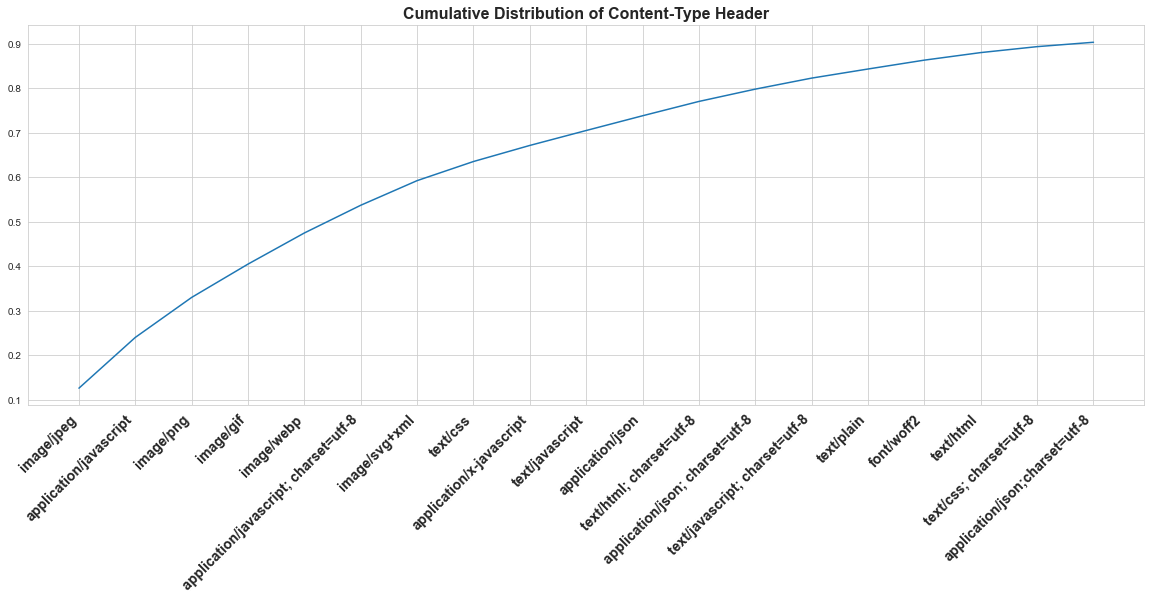

In [576]:
plt.figure(figsize=(20, 7))
plt.plot(
    (
        data["content-type"].value_counts().cumsum()
        / data["content-type"].value_counts().sum()
    )[0:19]
)
plt.title(
    "Cumulative Distribution of Content-Type Header", fontsize=16, fontweight="bold"
)
plt.xticks(rotation=45, fontsize=14, fontweight="bold", ha="right")

In [21]:
def create_value_comparison(header_field, n_values):
    header_field_df = pd.DataFrame(
    data[[f"{header_field}", "tracker"]].value_counts()
        ).reset_index()
    header_field_df.columns = [f"{header_field}", "tracker", "frequency"]
    header_field_df.sort_values(by=["frequency"], ascending=False, inplace=True)

    test_values = header_field_df[0:n_values][f"{header_field}"].values.tolist()
    frequent_content_types = (
        header_field_df[header_field_df[f"{header_field}"].isin(test_values)]
        .reset_index()
        .sort_values(by=f"{header_field}")
    )
    non_tracker = frequent_content_types[frequent_content_types.tracker == 0]
    tracker = frequent_content_types[frequent_content_types.tracker == 1]
    return non_tracker, tracker

In [22]:
def create_value_comparison_plot(non_tracker, tracker, n, header_field):
    r = np.arange(n)
    width = 0.25

    plt.figure(figsize=(20, 7))
    plt.bar(r, non_tracker["frequency"], log=True, label="Non Tracker", width=width)
    plt.bar(r + width, tracker["frequency"], log=True, label="Tracker", width=width)
    plt.xticks(
        r + width / 2,
        non_tracker[f"{header_field}"].values.tolist(),
        rotation=45,
        fontsize=12,
        fontweight="bold",
        ha="right",
    )
    plt.legend()

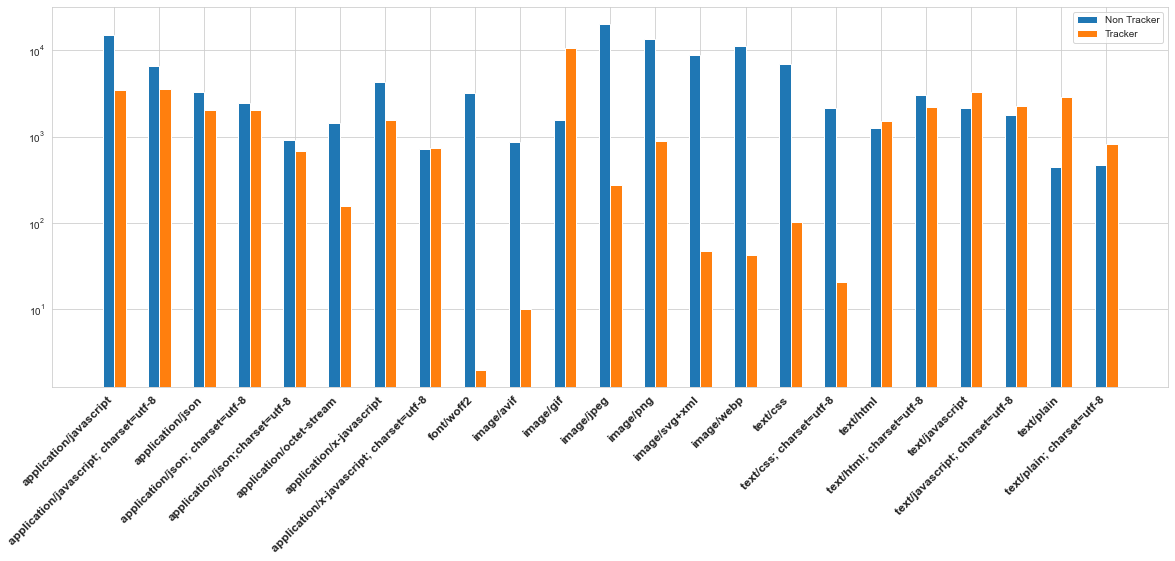

In [77]:
non_tracker_ct, tracker_ct = create_value_comparison("content-type", 34)
create_value_comparison_plot(non_tracker_ct, tracker_ct, len(tracker_ct))

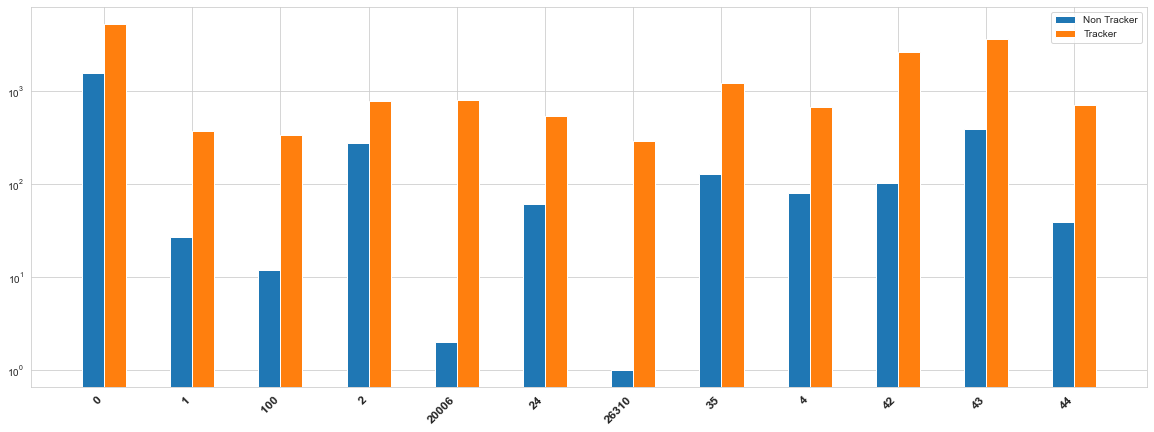

In [105]:
non_tracker_cl, tracker_cl = create_value_comparison("content-length", 14)
create_value_comparison_plot(non_tracker_cl, tracker_cl, len(tracker_cl), 'content-length')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

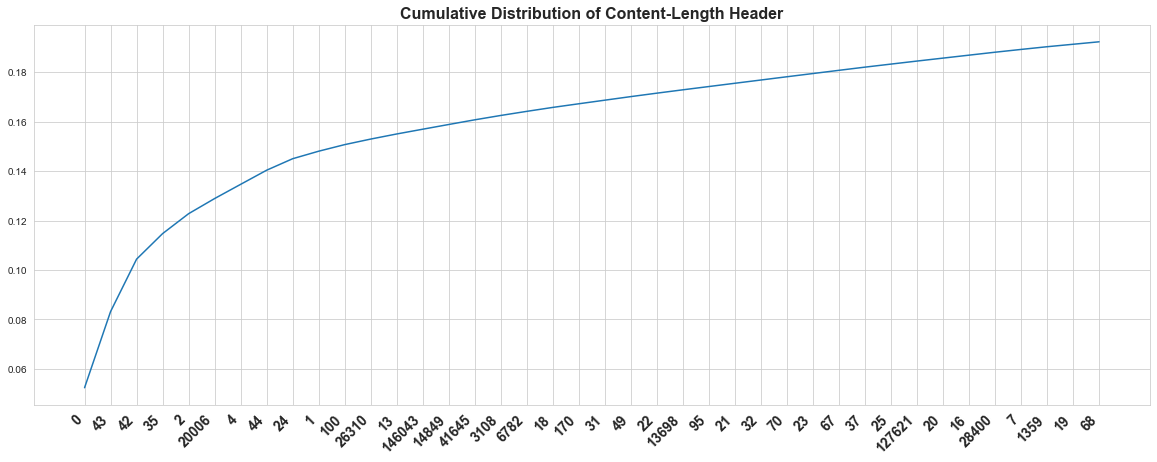

In [143]:
plt.figure(figsize=(20, 7))
plt.plot(
    (
        data["content-length"].value_counts().cumsum()
        / data["content-length"].value_counts().sum()
    )[0:40]
)
plt.title(
    "Cumulative Distribution of Content-Length Header", fontsize=16, fontweight="bold"
)
plt.xticks(rotation=45, fontsize=14, fontweight="bold", ha="right")

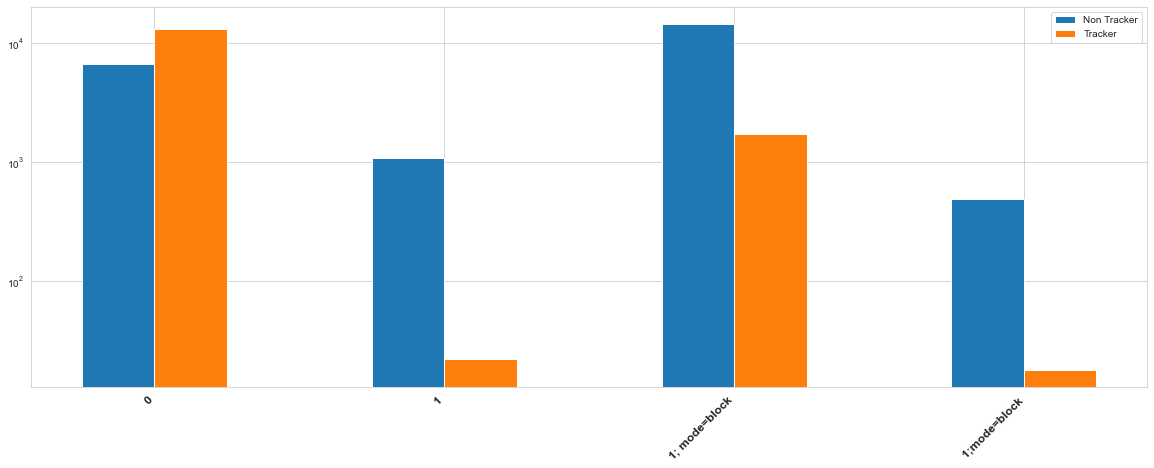

In [122]:
non_tracker_xss, tracker_xss = create_value_comparison("x-xss-protection", 6)
create_value_comparison_plot(non_tracker_xss, tracker_xss, len(tracker_xss), 'x-xss-protection')

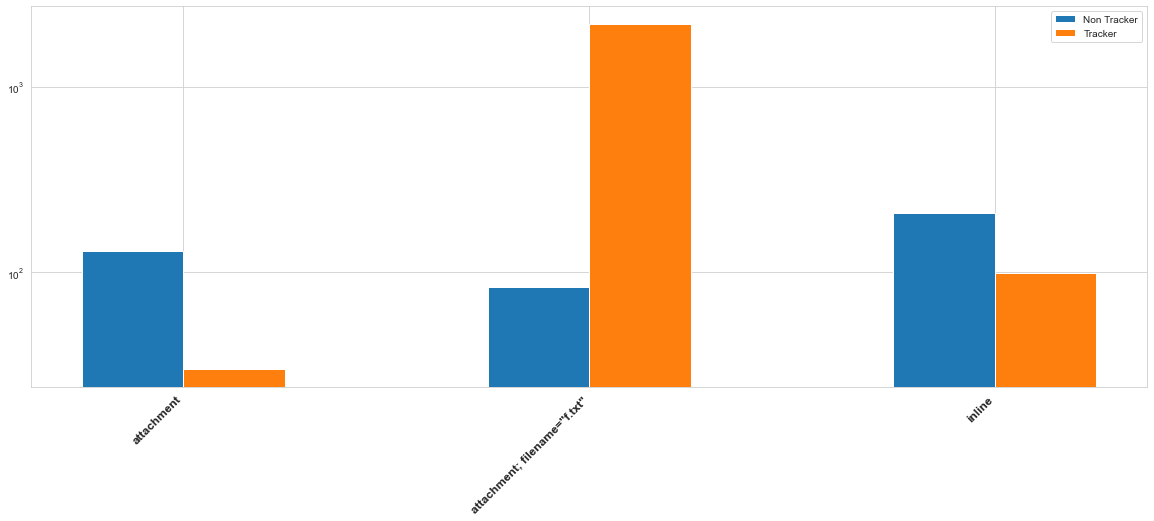

In [124]:
non_tracker_cd, tracker_cd = create_value_comparison("content-disposition", 4)
create_value_comparison_plot(non_tracker_cd, tracker_cd, len(tracker_cd), 'content-disposition')

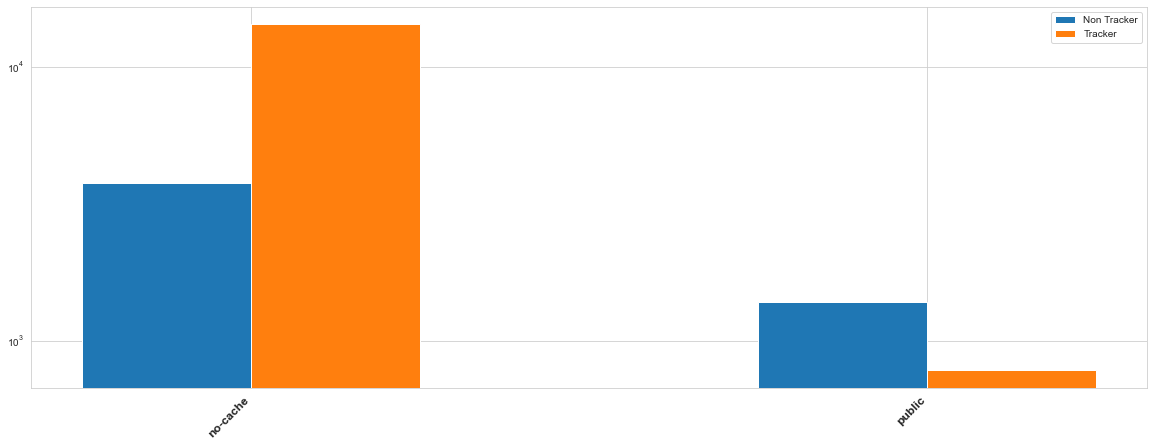

In [125]:
non_tracker_p, tracker_p = create_value_comparison("pragma", 4)
create_value_comparison_plot(non_tracker_p, tracker_p, len(tracker_p), 'pragma')

In [95]:
non_tracker_cl

,index,server,tracker,frequency
2,2,amazons3,0,11006
4,4,apache,0,5094
16,139,cafe,0,83
1,1,cloudflare,0,18901
0,0,nginx,0,21803
9,9,server,0,3464
6,6,sffe,0,3920
7,7,tengine,0,3770


In [96]:
tracker_cl

,index,server,tracker,frequency
12,13,amazons3,1,2046
13,22,apache,1,780
3,3,cafe,1,6459
10,10,cloudflare,1,2518
8,8,golfe2,1,3554
5,5,nginx,1,4081
14,26,server,1,611
11,11,sffe,1,2478
15,62,tengine,1,196


In [97]:
pd.DataFrame(
    data[[f"server", "tracker"]].value_counts()
        ).reset_index()

,server,tracker,0
0,nginx,0,21803
1,cloudflare,0,18901
2,amazons3,0,11006
3,cafe,1,6459
4,apache,0,5094
...,...,...,...
1413,mt3 4409 ba5503e master zrh-pixel-x9 config:1.0.0,1,1
1414,mt3 4409 ba5503e master zrh-pixel-x4 config:1.0.0,0,1
1415,mt3 4409 ba5503e master zrh-pixel-x31 config:1...,1,1
1416,mt3 4409 ba5503e master zrh-pixel-x29 config:1...,1,1


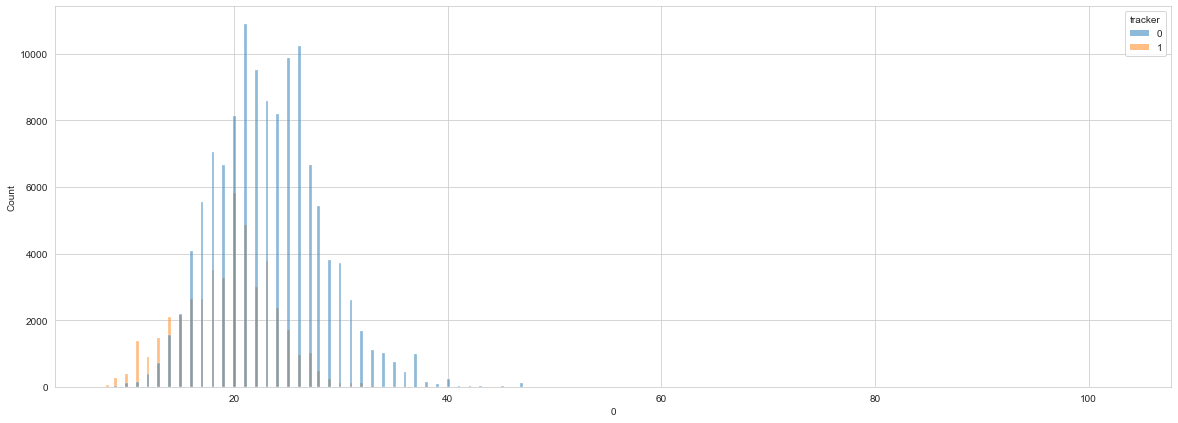

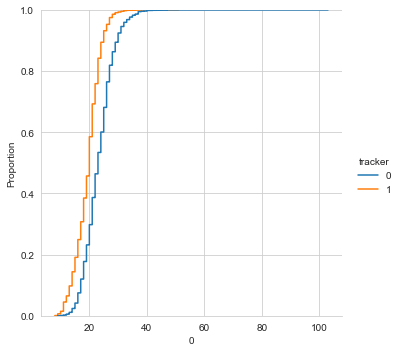

In [23]:
plt.figure(figsize=(20, 7))
# TODO change var name, a bit misleading here
na_per_row = pd.DataFrame((data.isnull().sum(axis=1) - len(data.columns))*-1)
na_per_row["tracker"] = data["tracker"]

sns.histplot(na_per_row, hue='tracker', x=na_per_row.columns.values[0])
sns.displot(na_per_row, hue='tracker', x=na_per_row.columns.values[0], kind='ecdf')

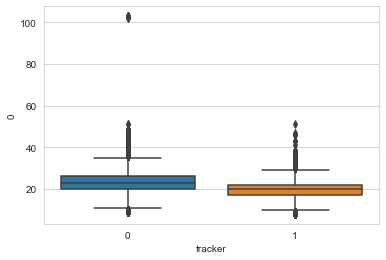

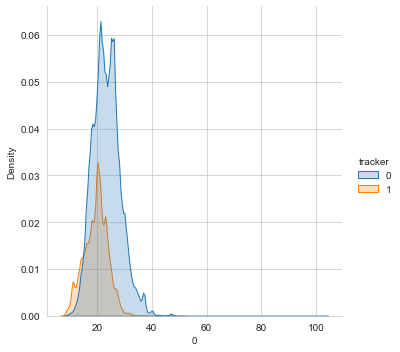

In [24]:
sns.boxplot(data=na_per_row, y=na_per_row.columns.values[0], x='tracker')
sns.displot(na_per_row, hue='tracker', x=na_per_row.columns.values[0], kind='kde', fill=True)

In [371]:
less_ten_headers = data[((data.isnull().sum(axis=1) - len(data.columns))*-1) <= 10].dropna(axis=1, how='all')

less_ten_headers

,hostname,pathname,filetype,filename,protocol,query,content-type,cache-control,pragma,date,...,access-control-allow-credentials,x-azure-ref,set-cookie,connection,transfer-encoding,x-amzn-requestid,apigw-requestid,x-33x-status,server-info,tracker
483,js.bd.dhsz.cn,/js/PDPS000000058043.js,js,PDPS000000058043.js,https:,[],text/javascript; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:54 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
507,js.bd.dhsz.cn,/js/PDPS000000058046.js,js,PDPS000000058046.js,https:,[],text/javascript; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:54 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
539,js.bd.dhsz.cn,/js/PDPS000000016827.js,js,PDPS000000016827.js,https:,[],text/javascript; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:55 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
555,js.bd.dhsz.cn,/impress,/impress,impress,https:,"[[p, PDPS000000058043], [u, 1], [pf, baidu], [...",application/json; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:56 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
557,js.bd.dhsz.cn,/impress,/impress,impress,https:,"[[p, PDPS000000058046], [u, 1], [pf, baidu], [...",application/json; charset=utf-8,NaN,NaN,"wed, 18 may 2022 13:15:56 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166373,clients1.google.com,/generate_204,/generate_204,generate_204,https:,[],NaN,NaN,NaN,"wed, 18 may 2022 15:05:51 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
166419,tpc.googlesyndication.com,/generate_204,/generate_204,generate_204,https:,"[[r9S9pg, ]]",NaN,NaN,NaN,"wed, 18 may 2022 15:05:53 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
167493,tpc.googlesyndication.com,/generate_204,/generate_204,generate_204,https:,"[[iFvV0A, ]]",NaN,NaN,NaN,"wed, 18 may 2022 15:06:22 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
167509,tpc.googlesyndication.com,/generate_204,/generate_204,generate_204,https:,"[[uc6SIw, ]]",NaN,NaN,NaN,"wed, 18 may 2022 15:06:23 gmt",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [226]:
%%time
data['content-length'].sample(10000, random_state=10).astype('Int64')

CPU times: user 6.54 ms, sys: 862 µs, total: 7.4 ms
Wall time: 6.47 ms


70111      1048
87064      <NA>
31806     78913
68645      6504
1358      64320
          ...  
118088    40160
65138       471
155259     <NA>
108876     <NA>
33634     61806
Name: content-length, Length: 10000, dtype: Int64

In [5]:
columns_as_category = {i: 'category' for i in data.columns.values[:-2]}

In [6]:
columns_as_category

{'hostname': 'category',
 'pathname': 'category',
 'filetype': 'category',
 'filename': 'category',
 'protocol': 'category',
 'query': 'category',
 'pragma': 'category',
 'content-type': 'category',
 'last-modified': 'category',
 'accept-ranges': 'category',
 'etag': 'category',
 'p3p': 'category',
 'x-xss-protection': 'category',
 'x-content-type-options': 'category',
 'strict-transport-security': 'category',
 'x-robots-tag': 'category',
 'vary': 'category',
 'content-encoding': 'category',
 'cache-control': 'category',
 'expires': 'category',
 'date': 'category',
 'content-length': 'category',
 'connection': 'category',
 'x-amz-server-side-encryption': 'category',
 'x-amz-version-id': 'category',
 'server': 'category',
 'x-cache': 'category',
 'via': 'category',
 'x-amz-cf-pop': 'category',
 'x-amz-cf-id': 'category',
 'age': 'category',
 'x-guploader-uploadid': 'category',
 'x-goog-generation': 'category',
 'x-goog-metageneration': 'category',
 'x-goog-stored-content-encoding': 'cat

In [3]:
column_test = data.columns.values[6:-2].tolist()


def test_new_categories_update(element):
    categories = data[element].astype("category").cat.categories.values.tolist()
    try:
        np.array(categories, dtype='int64')
        return {element: "Int64"}
    except (ValueError, OverflowError):
        return None

In [4]:
%%time
braze3 = [test_new_categories_update(element) for element in column_test]

CPU times: user 12 s, sys: 243 ms, total: 12.3 s
Wall time: 12.4 s


In [7]:
braze3 = list(filter(lambda x: type(x) is dict, braze3))
braze3 = {k: v for d in braze3 for k, v in d.items()}
braze3

{'content-length': 'Int64',
 'x-goog-generation': 'Int64',
 'x-goog-metageneration': 'Int64',
 'x-goog-stored-content-length': 'Int64',
 'akamai-true-ttl': 'Int64',
 'x-serial': 'Int64',
 'x-fb-rlafr': 'Int64',
 'x-content-cdn-origin-ts': 'Int64',
 'x-origin-upstream-status': 'Int64',
 'x-edgeconnect-midmile-rtt': 'Int64',
 'x-edgeconnect-origin-mex-latency': 'Int64',
 'x-edgeconnect-cache-status': 'Int64',
 'x-envoy-attempt-count': 'Int64',
 'x-envoy-upstream-service-time': 'Int64',
 'device_detected_ismobilephone': 'Int64',
 'x-scrolljs': 'Int64',
 'x-cp-r': 'Int64',
 'actual-object-ttl': 'Int64',
 'x-mol-georesp': 'Int64',
 'x-rs-ben-time': 'Int64',
 'x-rs-time': 'Int64',
 'x-rs-ben': 'Int64',
 'accept-ch-lifetime': 'Int64',
 'x-age-lb': 'Int64',
 'x-edge-pop': 'Int64',
 'x-lb-ip': 'Int64',
 'x-lb-pop': 'Int64',
 'x-edge-origin-shield-bytes': 'Int64',
 'se': 'Int64',
 'x-payload-length': 'Int64',
 'x-flipkart-ab-ids': 'Int64',
 'x-content-language': 'Int64',
 'unused62': 'Int64',
 '

In [8]:
columns_as_category.update(braze3)
columns_as_category

{'hostname': 'category',
 'pathname': 'category',
 'filetype': 'category',
 'filename': 'category',
 'protocol': 'category',
 'query': 'category',
 'pragma': 'category',
 'content-type': 'category',
 'last-modified': 'category',
 'accept-ranges': 'category',
 'etag': 'category',
 'p3p': 'category',
 'x-xss-protection': 'category',
 'x-content-type-options': 'category',
 'strict-transport-security': 'category',
 'x-robots-tag': 'category',
 'vary': 'category',
 'content-encoding': 'category',
 'cache-control': 'category',
 'expires': 'category',
 'date': 'category',
 'content-length': 'Int64',
 'connection': 'category',
 'x-amz-server-side-encryption': 'category',
 'x-amz-version-id': 'category',
 'server': 'category',
 'x-cache': 'category',
 'via': 'category',
 'x-amz-cf-pop': 'category',
 'x-amz-cf-id': 'category',
 'age': 'category',
 'x-guploader-uploadid': 'category',
 'x-goog-generation': 'Int64',
 'x-goog-metageneration': 'Int64',
 'x-goog-stored-content-encoding': 'category',
 

In [16]:
del columns_as_category["query"]
del columns_as_category["protocol"]
data.drop(['protocol', 'query'], axis=1, inplace=True)

In [17]:
data = data.astype(columns_as_category)

ValueError: invalid literal for int() with base 10: 'de'

In [12]:
data.dtypes

hostname              category
pathname              category
filetype              category
filename              category
pragma                category
                        ...   
x-ta                     Int64
x-cache-cms-status    category
x-pbs-appsvrname         Int64
x-pbs-appsvrip        category
tracker                  int32
Length: 5314, dtype: object

In [93]:
def variance_per_column(column):
    unique_values = int(len(set(data[column]))) - 1
    na_values = data[column].isna().sum()
    rows_with_values = data[column].value_counts().sum()
    ratio_real_values =  round(rows_with_values / unique_values, 3)
    tracker_ratio = data[data[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, unique_values, rows_with_values,
            na_values, round(na_values / len(data), 3), round(rows_with_values/ len(data), 3),
            ratio_real_values, trackers, non_trackers]

In [34]:
def reduced_variance_per_column(column):
    unique_values = int(len(set(data[column]))) - 1
    na_values = data[column].isna().sum()
    return [column, unique_values, round(na_values / len(data), 3)]

In [150]:
%%time
number_of_elements = np.array([variance_per_column(column) for column in data.iloc[:, 4:].columns])

CPU times: user 8min 48s, sys: 6.6 s, total: 8min 55s
Wall time: 8min 59s


In [35]:
number_of_elements_reduced = np.array([reduced_variance_per_column(column) for column in data.iloc[:, 4:-2].columns])

In [36]:
summary_table = pd.DataFrame(number_of_elements_reduced, columns=["header_name",
                                                          "unique_values",
                                                          "na_ratio"])
summary_table['unique_values'] = summary_table['unique_values'].astype("Int32")
summary_table["na_ratio"] = summary_table["na_ratio"].astype("float32")

In [152]:
summary_table = pd.DataFrame(number_of_elements, columns=['header_name', 'unique_values',
                                                          'non_nas', 'nas', 'na_ratio',
                                                          'non_na_ratio', 'ratio_real_values',
                                                          'trackers', 'non_trackers'])

summary_table['unique_values'] = summary_table['unique_values'].astype("Int32")
summary_table['non_nas'] = summary_table['non_nas'].astype("Int32")
summary_table['nas'] = summary_table['nas'].astype("Int32")
summary_table['na_ratio'] = summary_table['na_ratio'].astype("float32")
summary_table['non_na_ratio'] = summary_table['non_na_ratio'].astype("float32")
summary_table['ratio_real_values'] = summary_table['ratio_real_values'].astype("float32")
summary_table['trackers'] = summary_table['trackers'].astype("Int32")
summary_table['non_trackers'] = summary_table['non_trackers'].astype("Int32")

summary_table.sort_values(by='ratio_real_values', ascending=False, inplace=True)
summary_table.reset_index(drop=True, inplace=True)
summary_table.drop([0], inplace=True)
summary_table.reset_index(drop=True, inplace=True)

In [98]:
summary_table

,header_name,unique_values,na_ratio
0,pragma,13,0.887
1,content-type,324,0.032
2,last-modified,88351,0.309
3,accept-ranges,2,0.499
4,etag,113969,0.435
...,...,...,...
4442,x-amz-req-time-micros,3,1.000
4443,debug_plat_b,1,1.000
4444,x-ta,1,1.000
4445,x-pbs-appsvrname,1,1.000


In [142]:
summary_table[summary_table['header_name'] == 'date']

,header_name,unique_values,non_nas,nas,na_ratio,non_na_ratio,ratio_real_values,trackers,non_trackers
920,date,22923,166815,1223,0.007,0.993,7.277,44641,122174


In [37]:
remove_headers_with_one_na_ratio = summary_table[summary_table['na_ratio'] == 1].header_name.values.tolist()

data.drop(remove_headers_with_one_na_ratio, axis=1, inplace=True)

In [38]:
# summary_table[(summary_table['unique_values'] <= 1) & (summary_table['na_ratio'] != 1)].header_name.values.tolist()

remove_headers_with_one_value = summary_table[(summary_table['unique_values'] <= 1) & (summary_table['na_ratio'] != 1)].header_name.values.tolist()

In [39]:
data.drop(remove_headers_with_one_value, axis=1, inplace=True)

In [40]:
data

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,z-stale-enabled,z-fastly-info-state,z-backend-name,z-react-reason,z-polopoly-beckend,z-url-original,z-url-modified,z-surrogate-keys,z-actions-log,tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,NaN,NaN,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
272000,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,NaN,"fri, 12 aug 2022 09:22:13 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
272001,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
272002,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


<AxesSubplot:xlabel='fastly-restarts'>

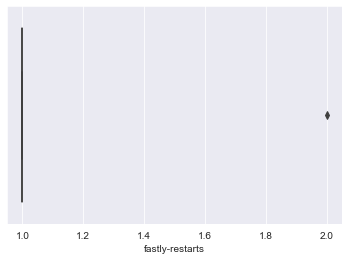

In [1112]:
sns.boxplot(data=data, x='fastly-restarts')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272004 entries, 0 to 272003
Columns: 488 entries, hostname to tracker
dtypes: Int64(67), category(420), int32(1)
memory usage: 357.2 MB


### Check ID Headers

In [261]:
%%time
# [print(col) for col in summary_table.header_name.values if '-id' in col]
id_headers = list(filter(lambda y: y != False, map(lambda x: x if x[-2:] == 'id' else False, summary_table.header_name
                                            .values)))

CPU times: user 137 µs, sys: 7 µs, total: 144 µs
Wall time: 146 µs


In [262]:
summary_table[summary_table['header_name'].isin(id_headers)]

,header_name,unique_values,non_nas,nas,na_ratio,non_na_ratio,ratio_real_values,trackers,non_trackers
76,lb_id,18,96,148964,0.999,0.001,5.333,52,44
95,x-amz-version-id,6646,10521,138539,0.929,0.071,1.583,1230,9291
100,txid,79,96,148964,0.999,0.001,1.215,52,44
103,x-amzn-trace-id,254,300,148760,0.998,0.002,1.181,99,201
106,request-id,353,409,148651,0.997,0.003,1.159,42,367
107,x-amz-apigw-id,291,329,148731,0.998,0.002,1.131,125,204
109,x-amz-request-id,7211,8108,140952,0.946,0.054,1.124,1110,6998
110,x-guploader-uploadid,1668,1813,147247,0.988,0.012,1.087,233,1580
114,x-li-uuid,155,163,148897,0.999,0.001,1.052,121,42
115,x-amzn-requestid,812,850,148210,0.994,0.006,1.047,607,243


#### Keep relevant columns

In [42]:
def variance_per_column_2(column):
    tracker_ratio = data[data[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, trackers, non_trackers]

In [43]:
number_of_elements_reduced = np.array([variance_per_column_2(column) for column in data.iloc[:, 4:-2].columns])
summary_table = pd.DataFrame(number_of_elements_reduced, columns=["header_name",
                                                                  "trackers",
                                                                  "non_trackers"])
summary_table['trackers'] = summary_table['trackers'].astype("Int32")
summary_table["non_trackers"] = summary_table["non_trackers"].astype("float32")
summary_table['ratio'] = (summary_table['trackers']/summary_table['non_trackers'])*100
summary_table['ratio2'] = (summary_table['non_trackers']/summary_table['trackers'])*100

In [44]:
summary_table

,header_name,trackers,non_trackers,ratio,ratio2
0,pragma,25805,8853.0,291.483113,34.307305
1,content-type,70183,191835.0,36.585086,273.335423
2,last-modified,27829,154469.0,18.015913,555.06486
3,accept-ranges,15119,116366.0,12.992627,769.667306
4,etag,18194,129781.0,14.019001,713.317577
...,...,...,...,...,...
478,z-polopoly-beckend,1,194.0,0.515464,19400.0
479,z-url-original,1,263.0,0.380228,26300.0
480,z-url-modified,1,263.0,0.380228,26300.0
481,z-surrogate-keys,1,277.0,0.361011,27700.0


In [45]:
only_non_tracker_col = summary_table[summary_table['ratio'] <= 10].header_name.values.tolist()

only_tracker_col = summary_table[summary_table['ratio2'] <= 10].header_name.values.tolist()

In [46]:
summary_table[summary_table['ratio'] <= 10]

,header_name,trackers,non_trackers,ratio,ratio2
39,akamai-true-ttl,13,1112.0,1.169065,8553.846154
40,server-timing,938,12025.0,7.800416,1281.982942
45,x-serial,7,1292.0,0.541796,18457.142857
46,x-check-cacheable,7,1667.0,0.419916,23814.285714
48,content-md5,195,8681.0,2.246285,4451.794872
...,...,...,...,...,...
478,z-polopoly-beckend,1,194.0,0.515464,19400.0
479,z-url-original,1,263.0,0.380228,26300.0
480,z-url-modified,1,263.0,0.380228,26300.0
481,z-surrogate-keys,1,277.0,0.361011,27700.0


In [64]:
only_tracker_col

['x-content-cdn-origin-ts',
 'dcs',
 'x-tid',
 'xserver',
 'google-lineitem-id',
 'google-creative-id',
 'google-mediationgroup-id',
 'google-mediationtag-id',
 'an-x-request-uuid',
 'x-proxy-origin',
 'ce-version',
 'abp',
 'x-sovrn-pod']

In [77]:
data[(data['google-creative-id'].notnull()) & (data['google-lineitem-id'].notnull())][['google-lineitem-id', 'google-creative-id']]

,google-lineitem-id,google-creative-id
398,-2,-2
636,-2,-2
982,"-2,-2,-2,-2","-2,-2,-2,-2"
1732,-2,-2
1796,5870547303,138399444920
...,...,...
270198,6071309237,138399359104
270241,-1,-1
271101,-2,-2
271320,-1,-1


# CHANGE COMBINATION TO +1 for each col in col_list

In [117]:
test_dict = {0: 2, 1:3}

test_dict

{0: 2, 1: 3}

In [78]:
data[(data['google-creative-id'].notnull()) & (data['tracker'] == 1)].index.tolist()

[398,
 636,
 982,
 1732,
 1796,
 2407,
 4153,
 4216,
 4410,
 5841,
 6061,
 7006,
 7312,
 8405,
 8482,
 9551,
 9806,
 10114,
 10702,
 11357,
 12845,
 14791,
 14820,
 16200,
 16261,
 16323,
 16417,
 16727,
 17473,
 17654,
 17819,
 18154,
 18337,
 19536,
 19580,
 19670,
 19730,
 20266,
 21749,
 22642,
 23443,
 23631,
 23714,
 23721,
 24021,
 24233,
 24509,
 24954,
 25394,
 26050,
 26554,
 26672,
 28595,
 28616,
 29477,
 31358,
 31727,
 32203,
 33861,
 34478,
 34969,
 35058,
 36794,
 37319,
 37340,
 37404,
 37490,
 37622,
 37639,
 37941,
 38112,
 38966,
 40210,
 41575,
 41648,
 42684,
 43043,
 45619,
 46079,
 46136,
 46219,
 46903,
 47249,
 47849,
 48082,
 48281,
 48342,
 48437,
 48713,
 50031,
 50402,
 50884,
 51528,
 51891,
 52610,
 52990,
 53002,
 53050,
 53710,
 56264,
 56292,
 56636,
 56689,
 57803,
 58555,
 58653,
 59056,
 59161,
 59765,
 60393,
 60536,
 60734,
 61162,
 61478,
 62368,
 62373,
 62380,
 62815,
 63438,
 63879,
 64652,
 65144,
 65678,
 65708,
 65761,
 65779,
 66089,
 670

In [101]:
def concise_information(col_list, classification, dataset):
    indices = list()

    for col in col_list:
        indices.append(dataset[(dataset[col].notnull()) & (dataset['tracker'] == classification)].index.tolist())

    return indices

In [48]:
data['comb_col_non_tracker'] = 0
data['comb_col_tracker'] = 0

In [102]:
from collections import Counter

tests = dict(Counter(list(np.concatenate(concise_information(only_tracker_col, 1, data)).flat)))
tests

{156: 1,
 683: 1,
 1188: 1,
 1314: 1,
 3745: 1,
 5259: 1,
 6097: 1,
 6779: 1,
 6838: 1,
 7043: 1,
 7106: 1,
 7218: 1,
 7633: 1,
 9798: 1,
 10705: 1,
 11214: 1,
 11802: 1,
 11967: 1,
 12283: 1,
 12776: 1,
 13262: 1,
 15185: 1,
 15237: 1,
 17137: 1,
 18239: 1,
 21263: 1,
 21568: 1,
 24321: 1,
 24971: 1,
 27064: 1,
 27334: 1,
 27481: 1,
 29319: 1,
 30719: 1,
 32011: 1,
 34166: 1,
 36036: 1,
 36455: 1,
 38157: 1,
 39586: 1,
 41200: 1,
 41384: 1,
 43234: 1,
 45511: 1,
 45808: 1,
 46895: 1,
 48750: 1,
 49286: 1,
 49907: 1,
 52636: 1,
 53111: 1,
 53255: 1,
 53708: 1,
 54122: 1,
 54172: 1,
 54896: 1,
 55184: 1,
 55724: 1,
 57171: 1,
 58674: 1,
 59399: 1,
 60881: 1,
 61545: 1,
 62831: 1,
 63289: 1,
 63407: 1,
 63484: 1,
 63677: 1,
 65489: 1,
 65814: 1,
 66253: 1,
 66683: 1,
 67963: 1,
 68558: 1,
 69753: 1,
 70415: 1,
 72447: 1,
 72873: 1,
 76893: 1,
 76929: 1,
 78797: 1,
 79739: 1,
 81291: 1,
 81451: 1,
 81475: 1,
 81602: 1,
 84113: 1,
 85245: 1,
 85611: 1,
 87518: 1,
 87909: 1,
 88603: 1,
 887

In [103]:
for key, value in tests.items():
    data.at[key, "comb_col_tracker"] = value

In [105]:
data[data['comb_col_tracker'] > 3]

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,z-backend-name,z-react-reason,z-polopoly-beckend,z-url-original,z-url-modified,z-surrogate-keys,z-actions-log,tracker,comb_col_non_tracker,comb_col_tracker
398,securepubads.g.doubleclick.net,/gampad/ads,/gampad/ads,ads,no-cache,text/plain; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
636,securepubads.g.doubleclick.net,/gampad/ads,/gampad/ads,ads,no-cache,text/plain; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
982,securepubads.g.doubleclick.net,/gampad/ads,/gampad/ads,ads,no-cache,text/plain; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
1732,pubads.g.doubleclick.net,/gampad/ads,/gampad/ads,ads,no-cache,text/xml; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
1796,pagead2.googlesyndication.com,/gampad/ads,/gampad/ads,ads,no-cache,text/plain; charset=utf-8,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269467,securepubads.g.doubleclick.net,/gampad/adx,/gampad/adx,adx,no-cache,text/javascript; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
269559,pubads.g.doubleclick.net,/gampad/ads,/gampad/ads,ads,no-cache,text/xml; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
270198,securepubads.g.doubleclick.net,/gampad/ads,/gampad/ads,ads,no-cache,text/plain; charset=utf-8,NaN,NaN,NaN,"policyref=""https://googleads.g.doubleclick.net...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4
271101,pagead2.googlesyndication.com,/gampad/ads,/gampad/ads,ads,no-cache,text/plain; charset=utf-8,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,4


In [110]:
%%time
for idx in concise_information(only_tracker_col, 1):
    data.at[idx, 'comb_col_tracker'] = 1

CPU times: user 157 ms, sys: 1.61 ms, total: 159 ms
Wall time: 159 ms


In [111]:
%%time
for idx in concise_information(only_non_tracker_col, 0):
    data.at[idx, 'comb_col_non_tracker'] = 1

CPU times: user 4.17 s, sys: 86.1 ms, total: 4.26 s
Wall time: 4.28 s


In [112]:
data.drop(only_non_tracker_col, axis=1, inplace=True)
data.drop(only_tracker_col, axis=1, inplace=True)

In [113]:
data

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,tracker,header_count,comb_col_non_tracker,comb_col_tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,NaN,NaN,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,1,17,0,0
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,14,1,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,1,13,0,0
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,10,1,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253633,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,22,1,0
253634,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,NaN,"fri, 12 aug 2022 09:22:13 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,8,0,0
253635,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0,0
253636,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,22,1,0


In [96]:
def impute_value(element):
    if data[element].dtype == 'category':
        data[element] = data[element].cat.add_categories('missing')
        data[element].fillna('missing', inplace=True)
    else:
        data[element].fillna(91219942022, inplace=True)

In [ ]:
[impute_value(value) for value in data.columns.values]

#### Outlier detection

In [2]:
list_of_categorical_cols = list(data.iloc[:, 4:-4].select_dtypes('category').columns.values
                                                      .tolist())

list_of_integer_cols = list(data.iloc[:, 4:-4].select_dtypes('Int64').columns.values
                                                      .tolist())

NameError: name 'data' is not defined

In [1]:
data.info()

NameError: name 'list_of_categorical_cols' is not defined

In [133]:
number_of_trackers = len(data[data['tracker'] ==1])
number_of_non_trackers = len(data[data['tracker'] == 0])

In [134]:
summary_table['ratio_tracker'] = summary_table['trackers'] / number_of_trackers
summary_table['ratio_non_tracker'] = summary_table['non_trackers'] / number_of_non_trackers

In [137]:
summary_table

,header_name,trackers,non_trackers,ratio,ratio2,ratio_tracker,ratio_non_tracker
0,pragma,20677,7905.0,261.568627,38.230885,0.312417,0.042170
1,content-type,60269,185229.0,32.537562,307.337105,0.910628,0.988130
2,last-modified,25037,150118.0,16.678213,599.584615,0.378294,0.800826
3,accept-ranges,13410,113631.0,11.801357,847.360179,0.202617,0.606181
4,etag,16414,126871.0,12.937551,772.943828,0.248006,0.676811
...,...,...,...,...,...,...,...
494,z-polopoly-beckend,1,194.0,0.515464,19400.0,0.000015,0.001035
495,z-url-original,1,263.0,0.380228,26300.0,0.000015,0.001403
496,z-url-modified,1,263.0,0.380228,26300.0,0.000015,0.001403
497,z-surrogate-keys,1,277.0,0.361011,27700.0,0.000015,0.001478


In [266]:
def impute_value(element, classification):
    if element in list_of_integer_cols:
        # print(element, classification)
        data.loc[data['tracker'] == classification, element]\
            .fillna(data[data['tracker']==classification][element].median())

    if element in list_of_categorical_cols:
        print(element, classification)
        data.loc[data['tracker'] == classification, element] = data.loc[data['tracker'] == classification, element]\
            .fillna(data[data['tracker']==classification][element].mode().iloc[0])

In [245]:
impute_col_list_t = summary_table[summary_table['ratio_tracker'] < 0.4].header_name.values.tolist()
impute_col_list_nt = summary_table[summary_table['ratio_non_tracker'] < 0.4].header_name.values.tolist()

In [256]:
for header in impute_col_list_t:
    impute_value(header, 0)

for header in impute_col_list_t:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 0)

KeyError: 'akamai-true-ttl'

In [253]:
impute_col_list_t

['pragma',
 'last-modified',
 'accept-ranges',
 'etag',
 'p3p',
 'x-xss-protection',
 'x-content-type-options',
 'strict-transport-security',
 'x-robots-tag',
 'connection',
 'x-amz-server-side-encryption',
 'x-amz-version-id',
 'x-cache',
 'via',
 'x-amz-cf-pop',
 'x-amz-cf-id',
 'age',
 'x-guploader-uploadid',
 'x-goog-generation',
 'x-goog-hash',
 'x-goog-storage-class',
 'cf-cache-status',
 'expect-ct',
 'report-to',
 'nel',
 'cf-ray',
 'access-control-allow-credentials',
 'set-cookie',
 'content-security-policy-report-only',
 'akamai-true-ttl',
 'server-timing',
 'access-control-expose-headers',
 'access-control-allow-headers',
 'access-control-max-age',
 'x-powered-by',
 'x-serial',
 'x-check-cacheable',
 'cross-origin-resource-policy',
 'content-md5',
 'x-ms-request-id',
 'x-ms-version',
 'x-ms-blob-type',
 'cross-origin-opener-policy-report-only',
 'content-security-policy',
 'cross-origin-opener-policy',
 'x-frame-options',
 'x-fb-debug',
 'priority',
 'timing-allow-origin',
 

In [259]:
data[['x-xss-protection', 'tracker']]

,x-xss-protection,tracker
0,0,1
1,NaN,0
2,0,1
3,NaN,0
4,NaN,0
...,...,...
253633,NaN,0
253634,NaN,1
253635,NaN,0
253636,1; mode=block,0


In [269]:
impute_value('x-xss-protection', 1)

x-xss-protection 1


In [270]:
data[['x-xss-protection', 'tracker']]

,x-xss-protection,tracker
0,0,1
1,1; mode=block,0
2,0,1
3,1; mode=block,0
4,1; mode=block,0
...,...,...
253633,1; mode=block,0
253634,0,1
253635,1; mode=block,0
253636,1; mode=block,0


In [63]:
data

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,z-backend-name,z-react-reason,z-polopoly-beckend,z-url-original,z-url-modified,z-surrogate-keys,z-actions-log,tracker,comb_col_non_tracker,comb_col_tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,NaN,NaN,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
272000,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,NaN,"fri, 12 aug 2022 09:22:13 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
272001,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
272002,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
